In [39]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

import subprocess
import os
import shutil
import json
from pathlib import Path
import pathlib

import pandas as pd
from optuna.visualization import plot_pareto_front
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

# Load and predict

## Load the data

In [20]:
data_path = Path("/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/imputation/chuncks")
test_data = list(data_path.glob("test_*.csv"))
len(test_data)

15

## Load the model

In [21]:
experiment_path = Path("/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14")
best_model_path = experiment_path / "checkpoints" / "model_best.pth"

# Load configuration of the best model
configurations = (experiment_path / "configuration.json")
with open(configurations) as f:
    config_dict = json.load(f)

test_configurations = "/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/configs/config_test.json"
with open(test_configurations) as f:
    test_config_dict = json.load(f)

keys_to_overwrite = ["test_only", "data_dir", "data_class"]
for key in keys_to_overwrite:
    config_dict[key] = test_config_dict[key]

config_dict["load_model"] = best_model_path

need_root_dir = ["save_dir", "output_dir", "tensorboard_dir"]
for key in need_root_dir:
    config_dict[key] = Path("/Users/oliver/TU_BERLIN/MASTER") / config_dict[key]


# Save the updated config_dict to a JSON file
updated_config_path = experiment_path / "prediction_config.json"
# Convert pathlib path objects to strings
for key, value in config_dict.items():
    if isinstance(value, pathlib.PosixPath):
        config_dict[key] = str(value)
with open(updated_config_path, "w") as f:
    json.dump(config_dict, f)

with open(test_configurations, "w+") as f:
    json.dump(config_dict, f, indent=4)
    
updated_config_path

PosixPath('/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14/prediction_config.json')

## Impute test data with the model

In [22]:
# Get the root directory of the project
root_dir = Path(os.getcwd()).parent
print(root_dir)

# Set the working directory to the root directory of the project
os.chdir(root_dir)


# Define the command to run the Python file
command = ["python", f"{root_dir}/src/main.py", "--config", str(updated_config_path)]

# Run the command
subprocess.run(command)

os.chdir(root_dir/"analysis_pipeline")

/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_


2024-07-16 15:25:41,182 | INFO : Reading configuration ...
2024-07-16 15:25:41,184 | INFO : Reading configuration ...
2024-07-16 15:25:41,195 | INFO : Stored configuration file in '/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14/TEST_experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-16_15-25-41'
2024-07-16 15:25:41,195 | INFO : Running:
/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/src/main.py --config /Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14/prediction_config.json

2024-07-16 15:25:41,196 | INFO : Using device: cpu
/Users/oliver/miniconda3/envs/mvts/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for bett

2024-07-16 15:25:41,195 | INFO : Running:
/Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/src/main.py --config /Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14/prediction_config.json

2024-07-16 15:25:41,196 | INFO : Using device: cpu
Loaded model from /Users/oliver/TU_BERLIN/MASTER/mvts_transformer_/outputs/experiment_transformer_RAdam_88_0.11107716552857533_8_relu_True_2024-07-15_13-26-14/checkpoints/model_best.pth. Epoch: 10
2024-07-16 15:25:41,864 | INFO : Evaluating on test set ...
2024-07-16 15:25:41,865 | INFO : DEVICE IS: cpu


2024-07-16 15:25:41,864 | INFO : Evaluating on test set ...
2024-07-16 15:25:41,865 | INFO : DEVICE IS: cpu


Evaluating   0.0% | batch:         0 of         1	|	loss: 0.380044	|	snr: -14.6617	|	correlation: 0.793719


In [23]:

test_dir = sorted(list(experiment_path.glob("TEST_*")))[-1]
# Remove all other TEST_directories within the directory except the last one
for directory in experiment_path.glob("TEST_*"):
    if directory != test_dir:
        shutil.rmtree(directory)


# per_batch_test_data = np.load(test_dir / "per_batch_test.npy", allow_pickle=True)
per_batch_test_loaded = torch.load(test_dir / "per_batch_test.pt")
per_batch_test_loaded.keys()

dict_keys(['target_masks', 'targets', 'predictions', 'metrics', 'IDs'])

# Analysis

In [24]:
per_batch_test_loaded.keys()

dict_keys(['target_masks', 'targets', 'predictions', 'metrics', 'IDs'])

In [25]:

def plot_channels(matrix):
    # Extract the first 5 channels from the matrix
    channels = matrix[:, :5]

    # Plot the channels
    fig, axs = plt.subplots(5, 1, figsize=(10, 10))
    for i in range(5):
        axs[i].plot(channels[:, i])
        axs[i].set_ylabel(f'Channel {i+1} Values')

    # Set the plot title and labels
    fig.suptitle('Visualization of First 5 Channels of Multivariate Time Series Data')
    axs[-1].set_xlabel('Time')

    # Display the plot
    plt.show()

In [33]:
per_batch_test_loaded["predictions"][0][0].shape

(1700, 428)

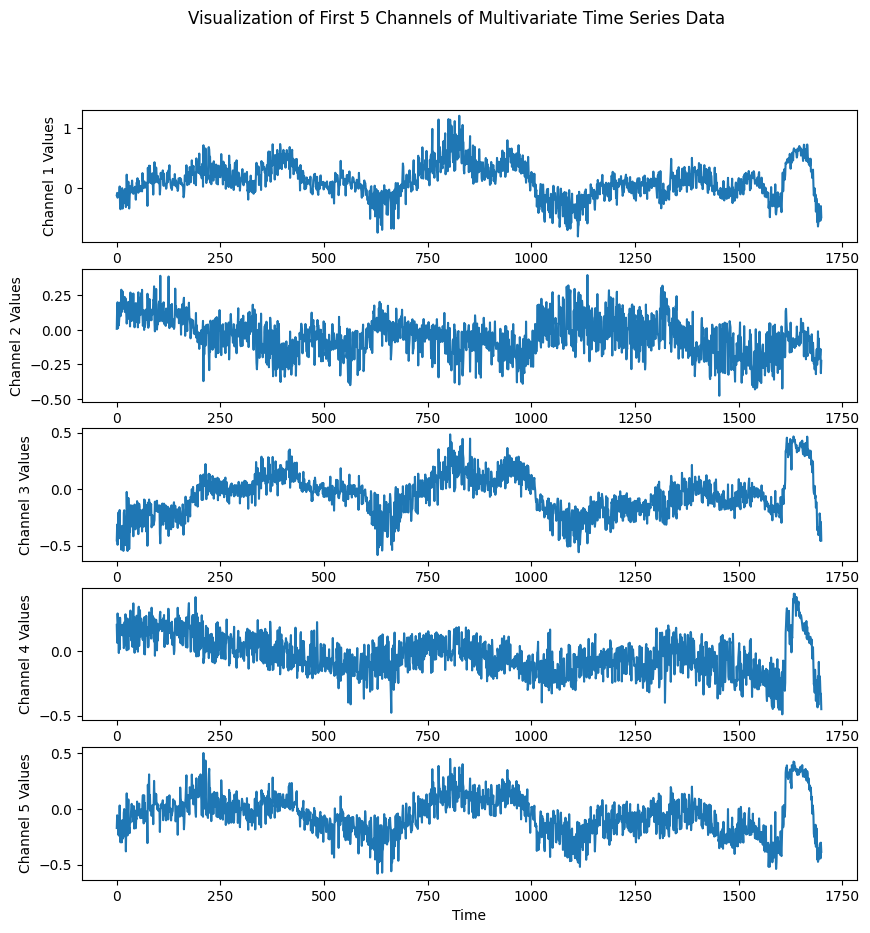

In [34]:
plot_channels(per_batch_test_loaded["predictions"][0][0])

In [35]:
def plot_predicted_time_series(true_series, predicted_series):
    # Create a time axis
    time = np.arange(len(true_series))

    # Plot the true time series
    plt.plot(time, true_series, label='True')

    # Plot the predicted time series
    plt.plot(time, predicted_series, label='Predicted')

    # Set the plot title and labels
    plt.title('True vs Predicted Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()

In [37]:
y_true = per_batch_test_loaded["targets"][0][0][:, 0]
y_pred = per_batch_test_loaded["predictions"][0][0][:, 0]

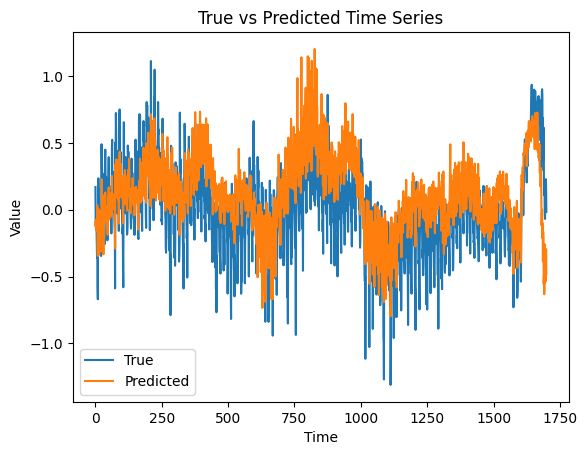

In [38]:
plot_predicted_time_series(y_true, y_pred)

In [66]:
def plot_time_series(y_pred, y_true, mask=None):
    # Create a time axis
    time = np.arange(len(y_pred))

    # Plot the predicted values
    plt.plot(time, y_pred, label='Predicted')

    # Plot the true values
    plt.plot(time, y_true, label='True')

    # Highlight the masked areas
    if mask is not None:
        masked_indices = np.where(mask)[0]
        plt.fill_between(time, np.min([y_pred, y_true]), np.max([y_pred, y_true]), where=mask, color='red', alpha=0.3)

    # Set the plot title and labels
    plt.title('Predicted vs True Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()


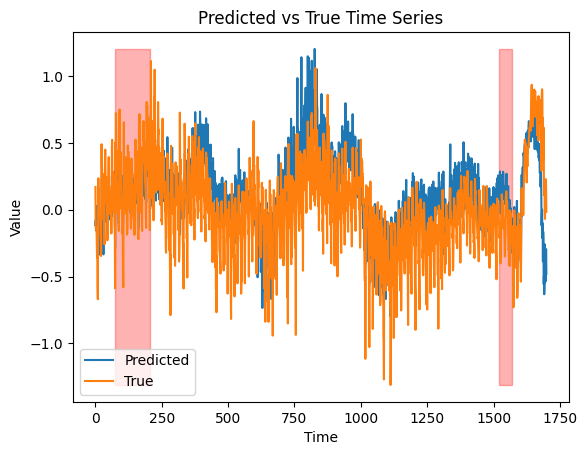

In [67]:
y_true = per_batch_test_loaded["targets"][0][0][:, 0]
y_pred = per_batch_test_loaded["predictions"][0][0][:, 0]
y_masked = per_batch_test_loaded["target_masks"][0][0][:, 0]
plot_time_series(y_pred, y_true, y_masked)

In [62]:
def compute_moving_averages(ts, lag):
    ts = np.convolve(ts, np.ones(lag)/lag, mode='valid')
    return ts

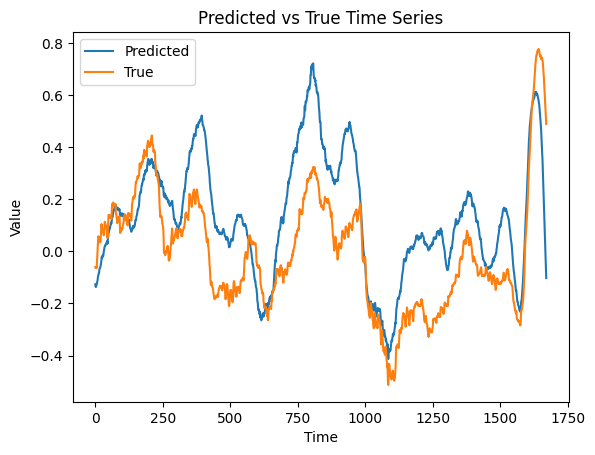

In [69]:
lag = 30
y_true = compute_moving_averages(per_batch_test_loaded["targets"][0][0][:, 0], lag)
y_pred = compute_moving_averages(per_batch_test_loaded["predictions"][0][0][:, 0], lag)
plot_time_series(y_pred, y_true)

In [49]:
np.where(y_masked)



(array([  73,   74,   75,   76,   77,   78,   79,   80,   81,   82,   83,
          84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,
          95,   96,   97,   98,   99,  100,  101,  102,  103,  104,  105,
         106,  107,  108,  109,  110,  111,  112,  113,  114,  115,  116,
         117,  118,  119,  120,  121,  122,  123,  124,  125,  126,  127,
         128,  129,  130,  131,  132,  133,  134,  135,  136,  137,  138,
         139,  140,  141,  142,  143,  144,  145,  146,  147,  148,  149,
         150,  151,  152,  153,  154,  155,  156,  157,  158,  159,  160,
         161,  162,  163,  164,  165,  166,  167,  168,  169,  170,  171,
         172,  173,  174,  175,  176,  177,  178,  179,  180,  181,  182,
         183,  184,  185,  186,  187,  188,  189,  190,  191,  192,  193,
         194,  195,  196,  197,  198,  199,  200,  201,  202,  203,  204,
         205, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531,
        1532, 1533, 1534, 1535, 1536, 

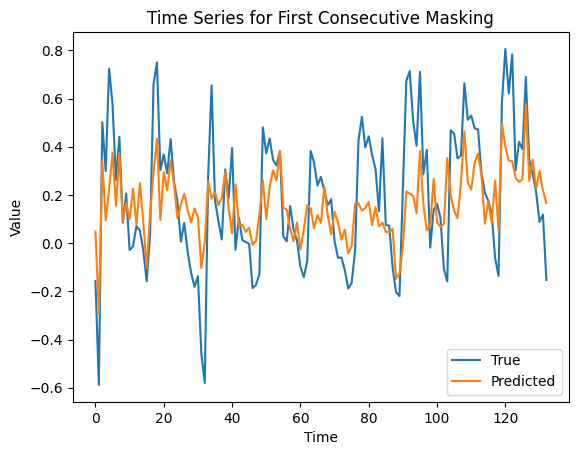

In [50]:

# Find the indices of the first consecutive masking
start_index = 73
end_index = 205

# Extract the masked time series
masked_y_true = y_true[start_index:end_index+1]
masked_y_pred = y_pred[start_index:end_index+1]

# Plot the masked time series
plt.plot(masked_y_true, label='True')
plt.plot(masked_y_pred, label='Predicted')
plt.title('Time Series for First Consecutive Masking')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Learning curve

In [59]:
train_metrics = experiment_path / "train_metrics_.csv"
val_metrics = experiment_path / "metrics_.csv"

train_metrics_df = pd.read_csv(train_metrics)
val_metrics_df = pd.read_csv(val_metrics)

merged_df = pd.merge(train_metrics_df, val_metrics_df, on='epoch')
merged_df.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y"], inplace=True)
merged_df


,epoch,loss_x,loss_y,SNR,Correlation
0,1,0.798898,0.346760,-14.722859,0.755895
1,2,0.504249,0.491581,-15.601630,0.724608
2,4,0.454838,0.509434,-16.809545,0.728311
3,6,0.423569,0.490324,-16.578578,0.735991
4,8,0.409989,0.454709,-16.833510,0.724203
5,10,0.397682,0.345917,-17.013987,0.714822
6,12,0.391088,0.428695,-16.738800,0.742623
7,14,0.387584,0.380535,-17.045071,0.774355
8,16,0.385273,0.492464,-17.604933,0.759045
9,18,0.380310,0.432220,-17.418617,0.758912


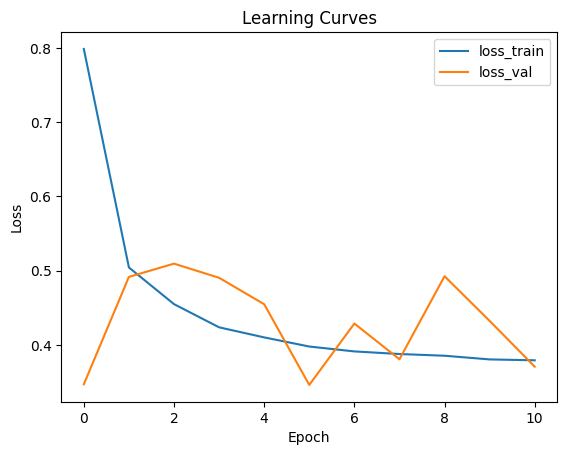

In [58]:
# Extract loss_x and loss_y from merged_df
loss_x = merged_df['loss_x']
loss_y = merged_df['loss_y']

# Plot learning curves
plt.plot(loss_x, label='loss_train')
plt.plot(loss_y, label='loss_val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()